## Study of the score calibration procedure used by HH-Suite

The neural network calibration used by default in HHsearch/HHblits/HHalign controls how hit score value is converted to the reported $P{\text -}value, E{\text -}value$, and $Probability$ for each reported hit.<br>
In HH-Suite v.2.x there is an option, "-calm" that can switch off this mode, whereas in HH-Suite v.3.x this option was deleted.<br>
See the [User Guide](https://github.com/soedinglab/hh-suite/wiki#dont-i-need-to-calibrate-my-query-or-database-hmm) for brief description of this feature.

Note: Use **Shift+Enter** to execute the code cells below. The order of execution is important (top to bottom). When some cell is modified it should be re-executed (all the dependent cells might also need update, **Cell/Run All Below** menu command does this).<br>**Ctrl-Z** undoes cell changes.<br>
**Kernel/Restart** menu command restarts the notebook from clean state.

In [1]:
import os
import sys
import csv
import math
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.path import Path
import matplotlib.patches as patches

%pylab inline
# print(numpy.__version__)
# print(matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib


These functions are adapted from HH-Suite 2.0.16 C++ code:

In [2]:
class Hit:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    def __repr__(self):
        return str(self.__dict__)

def CalculatePvalues(h):
    log1000 = math.log(1000.0)
    query_log_len = math.log(h.q_L)/log1000
    hit_log_len = math.log(h.t_L)/log1000
    h.lamda = lamda_NN(query_log_len, hit_log_len, h.q_Neff/10.0, h.t_Neff/10.0)
    h.mu = mu_NN(query_log_len, hit_log_len, h.q_Neff/10.0, h.t_Neff/10.0)
    h.logPval = logPvalue(h.score,h.lamda,h.mu)
    h.Pval = Pvalue(h.score,h.lamda,h.mu)
    h.Eval = math.exp(h.logPval + math.log(h.N_searched))
    h.logEval = h.logPval + math.log(h.N_searched)
    if h.logPval < -10.0:
        x = h.logPval
    else:
        # try:
        x = math.log(-math.log(1-h.Pval))
        #except ValueError:
        #    print("ValueError:", h.Pval, h.logPval, h.score, h.lamda, h.mu, file=sys.stderr)
        #    x = h.logPval
    h.score_aass = x/0.45 - min(h.lamda*h.score_ss,max(0.0,0.2*(h.score-8.0)))/0.45 - 3.0
    h.Probab = Probab(-h.score_aass, h.score_ss != 0.0)

def calc_hidden_output(weights, bias, Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Calculate output of hidden neural network units"
    # Calculate activation of hidden unit = sum of all inputs * weights + bias
    res = Lqnorm*weights[0] + Ltnorm*weights[1] + Nqnorm*weights[2] + Ntnorm*weights[3] + bias
    res = 1.0 / (1.0 + math.exp(-(res))) # logistic function
    return res

def lamda_NN(Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Neural network regressions of lamda for EVD"
    inputs = 4
    hidden = 4
    biases = [-0.73195, -1.43792, -1.18839, -3.01141] # bias for all hidden units
    weights = [ # Weights for the neural networks (column = start unit, row = end unit)
        -0.52356, -3.37650, 1.12984, -0.46796,
        -4.71361, 0.14166, 1.66807, 0.16383,
        -0.94895, -1.24358, -1.20293, 0.95434,
        -0.00318, 0.53022, -0.04914, -0.77046,
        2.45630, 3.02905, 2.53803, 2.64379
    ]
    lamda=0.0
    for h in range(hidden):
        lamda += calc_hidden_output(weights[inputs*h:], biases[h], Lqnorm,Ltnorm,Nqnorm,Ntnorm) * weights[hidden*inputs+h]
    return lamda

def mu_NN(Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Neural network regressions of mu for EVD"
    inputs = 4
    hidden = 6
    biases = [-4.25264, -3.63484, -5.86653, -4.78472, -2.76356, -2.21580]  # bias for all hidden units
    weights = [ # Weights for the neural networks (column = start unit, row = end unit)
        1.96172, 1.07181, -7.41256, 0.26471,
        0.84643, 1.46777, -1.04800, -0.51425,
        1.42697, 1.99927, 0.64647, 0.27834,
        1.34216, 1.64064, 0.35538, -8.08311,
        2.30046, 1.31700, -0.46435, -0.46803,
        0.90090, -3.53067, 0.59212, 1.47503,
        -1.26036, 1.52812, 1.58413, -1.90409, 0.92803, -0.66871
    ]
    mu=0.0
    for h in range(hidden):
        mu += calc_hidden_output(weights[inputs*h:], biases[h], Lqnorm,Ltnorm,Nqnorm,Ntnorm) * weights[hidden*inputs+h]
    return 20.0*mu

def Pvalue(x, lamda, mu):
    h = lamda*(x-mu)
    if h > 10:
        return math.exp(-h)
    else:
        return 1.0 - math.exp(-math.exp(-h))

def logPvalue(x, lamda, mu):
    h = lamda*(x-mu)
    if h > 10:
        return -h
    else:
        if h < -2.5:
            return -math.exp(-math.exp(-h))
        else:
            return math.log((1.0 - math.exp(-math.exp(-h))))

def Probab(s, has_ss):
    """
    Calculate probability of true positive : p_TP(score)/( p_TP(score)+p_FP(score) )
    TP: same superfamily OR MAXSUB score >=0.1
    """
    if s > 200:
        return 100.0
    if has_ss:
        # local with SS
        a=math.sqrt(6000.0)
        b=2.0*2.5
        c=math.sqrt(0.12)
        d=2.0*32.0
    else:
        # local no SS
        a=math.sqrt(4000.0)
        b=2.0*2.5
        c=math.sqrt(0.15)
        d=2.0*34.0
    t = a*math.exp(-s/b) + c*math.exp(-s/d)
    return 100.0/(1.0+t*t) # ??? JS Jul'12

Hit data from HHsearch results (profile's Neff can be found in the header of HMM file).<br>
The precise $Score$, $P{\text -}value$, and $Probability$ values are taken by modifying HHsearch source.

In [3]:
# Describe hits explicitly
hits = [
# NP_690588.1_1-2474 vs. PF01728.18 (iteration_1)
Hit(score=40.7270432, score_ss=-0.0733758, q_Neff=1.0, t_Neff=11.7, q_L=2474, t_L=183, N_searched=1,
    Probab_HH=77.7733154, Pval_HH=1.50802e-05, query='NP_690588.1', query_coords='1-2474',
    target='PF01728.18', iteration='1', comment='iteration #1'),
# NP_690588.1_1166-1348 vs. PF01728.18 (iteration_2)
Hit(score=39.3617821, score_ss=-0.0733758, q_Neff=1.0, t_Neff=11.7, q_L=(1348-1166+1), t_L=183, N_searched=1,
    Probab_HH=95.1556091, Pval_HH=1.15029e-07, query='NP_690588.1', query_coords='1166-1348',
    target='PF01728.18', iteration='2', comment='iteration #2')
]

# OR read hits from a file

# 2018 test cases:
# csv_file = 'YP_009126871.1-PF01003.18.csv'
# csv_file = 'NP_690588.csv'
# csv_file = 'YP_009052475.csv'
# three more cases (apart from 'YP_009126871.csv') with query length decrease for more than 30 times:
# csv_file = 'YP_009126871.1-PF01004.18.csv'
# csv_file = 'YP_004070193.2-PF14519.5.csv'
# csv_file = 'YP_009322132.1-PF01543.16.csv'

# 2019 test cases:
csv_file = "NP_690588.1-PF01728.18-15Aug2019.csv"
# four more cases with query length decrease for more than 30 times:
# csv_file = "YP_004070193.2-PF14519.5-15Aug2019.csv"
# csv_file = "YP_009126871.1-PF01003.18-15Aug2019.csv"
# csv_file = "YP_009322132.1-PF01543.16-15Aug2019.csv"
# csv_file = "YP_009179227.1-PF08301.12-15Aug2019.csv" # the highest probability gain
# and also one case with gain >25% but length decrease about 22x times:
# csv_file = "YP_009388303.1-PF13238.5-15Aug2019.csv"

if csv_file != '':
    f = open('input/' + csv_file)

    hits = []
    csv_reader = csv.reader(f)
    for r in csv_reader:
        if r[0] == 'Query':
            continue
        h = Hit(
            query=r[0],
            query_coords=r[1],
            target=r[2],
            iteration=r[3],
            comment=r[4],
            Probab_HH=float(r[5]),
            Pval_HH=float(r[6]),
            score=float(r[7]),
            score_ss=float(r[8]),
            q_L=int(r[9]),
            t_L=int(r[10]),
            q_Neff=float(r[11]),
            t_Neff=float(r[12]),
            N_searched=1,
           )
        hits.append(h)

print_probab_pval = True

for h in hits:
    CalculatePvalues(h)

    if print_probab_pval:
        print('HHsearch Probability:', h.Probab_HH)
        print('HHsearch P-value:', h.Pval_HH)
        print('Calculated Probability:', h.Probab)
        print('Calculated P-value:', h.Pval)
        print('')


HHsearch Probability: 77.8
HHsearch P-value: 1.5e-05
Calculated Probability: 77.58747256648266
Calculated P-value: 1.5230486898157602e-05

HHsearch Probability: 95.4
HHsearch P-value: 9e-08
Calculated Probability: 95.3553565039136
Calculated P-value: 9.031749341233687e-08



The above values match, it confirms that this calculation is correct (relative error $\approx$ 1e-06 for NP_690588.1 vs. PF01728.18 where precise HHsearch score and probability are known &ndash; modified HHsearch output was used).

### E-value and Probability as functions of query and target lengths

In [4]:
X = np.logspace(1, 6, num=51, base=10)
# print(X)

h = cp.copy(hits[0])

def resetHit():
    global h
    h = cp.copy(hits[0])

def getEvalueQLen(q_len):
    h.q_L = q_len
    CalculatePvalues(h)
    return h.Pval

def getEvalueTLen(t_len):
    h.t_L = t_len
    CalculatePvalues(h)
    return h.Pval

def testLengths(Z, func):
    for i, x in enumerate(X):
        resetHit()
        Z[i] = func(x)

def getProbabQLen(q_len):
    h.q_L = q_len
    CalculatePvalues(h)
    return h.Probab

def getProbabTLen(t_len):
    h.t_L = t_len
    CalculatePvalues(h)
    return h.Probab

NP_690588.1 vs. PF01728.18


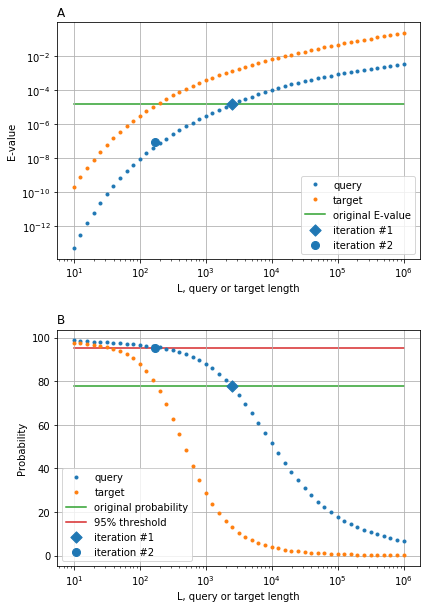

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(6.5,10)

QPval = X.copy()
testLengths(QPval, getEvalueQLen)

TPval = X.copy()
testLengths(TPval, getEvalueTLen)
# E-value = P-value (database size = 1)
color = next(ax1._get_lines.prop_cycler)['color']
markers = ['D', 'o', 'x', '+']
fix_scores = False # set to True if scores for iterations 2, 3, ... are by some reason different from iteration 1

ax1.loglog(X, QPval, marker='o', markersize=3, linestyle='', label='query', c=color)
ax1.loglog(X, TPval, marker='o', markersize=3, linestyle='', label='target')
ax1.plot(X, [hits[0].Pval] * len(X), '-', zorder=0, label='original E-value')


for (i, h) in enumerate(hits):
    if i > 0 and fix_scores:
        h.score = hits[0].score
        h.score_ss = hits[0].score_ss
        CalculatePvalues(h)
    ax1.scatter([h.q_L], [h.Pval], zorder=4, label=h.comment, marker=markers[i], c=color, s=64)


ax1.set_ylabel('E-value');
ax1.legend()
ax1.grid(True)
ax1.set_title('A', weight=550, size=12, loc='left')
ax1.set_xlabel('L, query or target length')
ax1.xaxis.set_tick_params(which='both', labelbottom=True)

QPval = X.copy()
testLengths(QPval, getProbabQLen)

TPval = X.copy()
testLengths(TPval, getProbabTLen)

color = next(ax2._get_lines.prop_cycler)['color']
# print('color:', color)
ax2.semilogx(X, QPval, marker='o', markersize=3, linestyle='', label='query', c=color)
ax2.semilogx(X, TPval, marker='o', markersize=3, linestyle='', label='target')
ax2.plot(X, [hits[0].Probab] * len(X), '-', zorder=0, label='original probability')
ax2.plot(X, [95] * len(X), '-', zorder=0, label='95% threshold')

for (i, h) in enumerate(hits):
    ax2.scatter([h.q_L], [h.Probab], zorder=4, label=h.comment, marker=markers[i], c=color, s=64)

ax2.set_ylabel('Probability');
ax2.legend()
ax2.grid(True)
ax2.set_title('B', weight=550, size=12, loc='left')
ax2.set_xlabel('L, query or target length')

plt.subplots_adjust(hspace=0.3)
pdffile = 'output/{}-{}-N1-15Aug2019.pdf'.format(hits[0].query, hits[0].target)
plt.savefig(pdffile, format='PDF')
print(hits[0].query, 'vs.', hits[0].target)

### Probability as a function of query and target lengths (continued)

Let's make 2D contour plot for Probability vs. query/traget profile lengths.

In [6]:
def getProbabLen(h, q_len, t_len):
    h.q_L = q_len
    h.t_L = t_len
    CalculatePvalues(h)
    return h.Probab

def getProbabNeff(h, q_Neff, t_Neff):
    h.q_Neff = q_Neff
    h.t_Neff = t_Neff
    CalculatePvalues(h)
    return h.Probab

hit = hits[0]
h = cp.copy(hit)

q_len = np.logspace(1, 5, 41, base=10)
t_len = np.logspace(1, 5, 41, base=10)
X,Y = np.meshgrid(q_len, t_len, indexing='ij')

def testLengths(Z, func, h):
    for i, x in enumerate(q_len):
        for j, y in enumerate(t_len):
            Z[i, j] = func(h, x, y)

P = X.copy()
testLengths(P, getProbabLen, h)

NP_690588.1 vs. PF01728.18


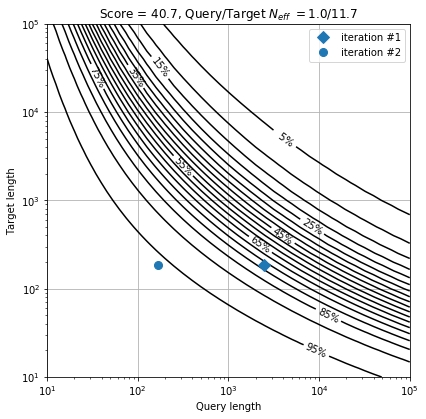

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(6.5,6.5)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
ax.set_title('Score = ' + ('%4.1f' % hit.score) + ', Query/Target $N_{eff}\ =' + str(hit.q_Neff) + '/' + str(hit.t_Neff) + '$')
ax.set_xlabel('Query length')
ax.set_ylabel('Target length')

levels = np.arange(0, 100, 5)

p = ax.contour(X, Y, P, levels=levels, colors='k')
ax.clabel(p, levels[1::2], inline=1, fmt='%2.0f%%', fontsize=10)
ax.plot([hits[0].q_L], [hits[0].t_L], zorder=4, linestyle='', label='iteration #1', marker='D', c=color, markersize=8)
ax.plot([hits[1].q_L], [hits[1].t_L], zorder=4, linestyle='', label='iteration #2', marker='o', c=color, markersize=8)

ax.grid(True)
ax.legend()
pdffile = 'output/{}-{}-N2-15Aug2019.pdf'.format(hits[0].query, hits[0].target)
plt.savefig(pdffile, format='PDF')
print(hits[0].query, 'vs.', hits[0].target)

### Probability as a function of query and target diversities

In [8]:
q_neff = np.linspace(0, 15, 48)
t_neff = np.linspace(0, 15, 48)
X,Y = np.meshgrid(q_neff, t_neff, indexing='ij')

def testNeff(Z, func, h):
    for i, x in enumerate(q_neff):
        for j, y in enumerate(t_neff):
            Z[i, j] = func(h, x, y)

h = cp.copy(hit)

P = X.copy()
testNeff(P, getProbabNeff, h)

NP_690588.1 vs. PF01728.18


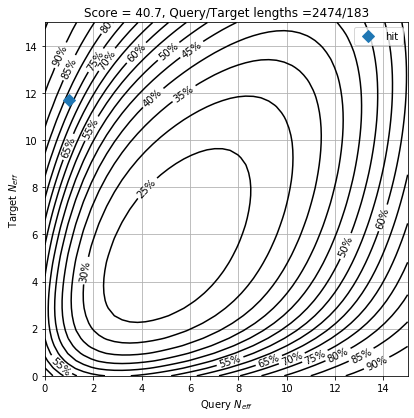

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(6.5,6.5)
ax.set_title('Score = ' + ('%4.1f' % hit.score) + ', Query/Target lengths =' + str(hit.q_L) + '/' + str(hit.t_L))
ax.set_xlabel('Query $N_{eff}$')
ax.set_ylabel('Target $N_{eff}$')

levels = np.arange(0, 100, 5)
p = ax.contour(X, Y, P, levels=levels, colors='k')
ax.clabel(p, levels[0::1], inline=1, fmt='%2.0f%%', fontsize=10)
ax.plot([hit.q_Neff], [hit.t_Neff], zorder=4, linestyle='', label='hit', marker='D', c=color, markersize=8)
ax.legend()
ax.grid(True)
pdffile = 'output/{}-{}-N3-15Aug2019.pdf'.format(hits[0].query, hits[0].target)
plt.savefig(pdffile, format='PDF')
print(hits[0].query, 'vs.', hits[0].target)

### Min. query length that generates Probability = 95% for a given score

This study concerns about up-voting of the hits for short query and target profiles. 

In [10]:
# scores
S = np.linspace(1, 100, num=100)

h = cp.copy(hits[0])

def getEvalueQLen(q_len):
    h.q_L = q_len
    CalculatePvalues(h)
    return h.Pval

def findQLenForProbab(score, probab, t_len=None, t_neff=None):
    """
    Binary search for the query length that gives specified probability value
    """
    a = 0
    b = 1000000
    count = 0
    while a < b and count < 30:
        count += 1
        c = (a + b) / 2
        resetHit()
        h.score = score
        h.score_ss = 0
        h.q_L = c
        if t_len is not None:
            h.t_L = t_len
        if t_neff is not None:
            h.t_Neff = t_neff
        try:
            CalculatePvalues(h)
        except ValueError:
            # print("ValueError:", h.q_L, h.score, h.lamda, h.mu, file=sys.stderr)
            h.Pval = 1
            h.logPval = 0
            h.Probab = 0

        if h.Probab > probab:
            a = c
        else:
            b = c
    return int(a + 0.5)
    
def testScores(Z, probab=95, t_len=None, t_neff=None):
    for i, s in enumerate(S):
        Z[i] = findQLenForProbab(s, probab, t_len, t_neff)

QL_T132_NE6 = np.zeros(len(S), dtype=np.int)
QL_T50_NE6 = np.zeros(len(S), dtype=np.int)
QL_T132_NE15 = np.zeros(len(S), dtype=np.int)
QL_T50_NE15 = np.zeros(len(S), dtype=np.int)

# PfamA profile lengths: median=132, mean=176; N_eff: median=6.5, mean=6.55, min=1.0, max=15.8
testScores(QL_T132_NE6, 95, 132, 6.5)
testScores(QL_T50_NE6, 95, 50, 6.5)
testScores(QL_T132_NE15, 95, 132, 15)
testScores(QL_T50_NE15, 95, 50, 15)

# print(list(zip(S, QL_T132_NE6)))

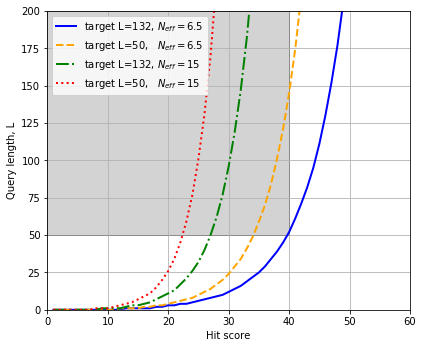

In [11]:
verts = [
    (0, 50),
    (40., 50),
    (40., 200.),
    (0, 200.),
    (0, 50)
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

path = Path(verts, codes)

fig, ax = plt.subplots()
fig.set_size_inches(6.5,5.5)
plot(S, QL_T132_NE6, label='target L=132, $N_{eff}=6.5$', color='blue', marker='', linestyle='-', linewidth=2)
plot(S, QL_T50_NE6, label='target L=50,   $N_{eff}=6.5$', color='orange', marker='', linestyle='--', linewidth=2)
plot(S, QL_T132_NE15, label='target L=132, $N_{eff}=15$', color='green', marker='', linestyle='-.', linewidth=2)
plot(S, QL_T50_NE15, label='target L=50,   $N_{eff}=15$', color='red', marker='', linestyle=':', linewidth=2)

plt.xlabel('Hit score')
plt.ylabel('Query length, L')

plt.title("")

patch = patches.PathPatch(path, facecolor='lightgray', lw=1)
ax.add_patch(patch)


plt.legend()
plt.ylim(0, 200)
plt.xlim(0, 60)
ax.grid(True)
plt.savefig('output/Figure-N5.pdf', format='PDF')

This figure shows max. query length that gives Probability=95% for a given score, target length ($L$) and target sequence diversity ($N_{eff}$). Gray rectangle shows area of FP hits of min. length 50aa if max. FP score is 40.0 (supposedly). Therefore the gray area under the lines presents possibilities for false hits with Probability > 95%. PfamA database has median profile length 132aa and diversity $N_{eff}=6.5$ (min. $N_{eff}=1.0$, max. $N_{eff}=15$). It follows that there is no gray area under the target $L=132aa$, $N_{eff}=6.5$. However, for shorter targets ($L=50aa$) and/or target profiles with higher diversity ($N_{eff}=6.5..15$) false hits with scores as low as 23.0 could be attributed with probability >95%.

Straightforward check for the probability=95% cases:

In [12]:
# test_hit = Hit(score=39.0, score_ss=0, q_Neff=1.0, t_Neff=6.5, q_L=45, t_L=132, N_searched=1)
# test_hit = Hit(score=20.0, score_ss=0, q_Neff=1.0, t_Neff=15, q_L=25, t_L=50, N_searched=1)
test_hit = Hit(score=23.0, score_ss=0, q_Neff=1.0, t_Neff=15, q_L=50, t_L=50, N_searched=1)
CalculatePvalues(test_hit)
print(test_hit)

{'score': 23.0, 'score_ss': 0, 'q_Neff': 1.0, 't_Neff': 15, 'q_L': 50, 't_L': 50, 'N_searched': 1, 'lamda': 0.8281435009894186, 'mu': 1.7486599093904132, 'logPval': -17.599159183354214, 'Pval': 2.2739571702268868e-08, 'Eval': 2.2739571702268868e-08, 'logEval': -17.599159183354214, 'score_aass': -42.10924262967603, 'Probab': 95.28633201048132}
